# The Fashion MNIST - transfer learning
This is the last time we will see the **fashion MNIST dataset**. This time we will use a pretrained CNN to process the images. For every image we want to classify it into **10 distinct clothing categories**. We will use the first layers from a known CNN, **ResNet50** and only use 10% of the dataset to speed up processing.

The **ResNet50** expects the input to have **3 colors**, but the Fashion MNIST dataset is only grayscale. We will "fix" this issue by copying the grayscale values as the colors Red, Green, Blue. These images will undboutably look strange, but this allows us to use the ResNet50 model. Furthermore, the minimal image input size is **32 by 32** pixels, and our images are 28 by 28. To fix this, we will resize our images. Thus, our training set will have dimensions `(6000, 32, 32, 1)`. Lastly, we will do our normal **Min/Max scaling** and map the labels to their **one-hot encoding representation**. 

We will then download the ResNet50 model and chop off the last layers. We will then construct a new model which uses the first layers of the ResNet50 as the input layer and **freeze** the weights, so we do not train them. After feeding the input to the ResNet50 we will use the computed representation as input to a **dense layer** and then to a **softmax layer**. This will allow us to output a 10 class probability distribution specific to our problem and train the CNN using **categorical_crossentropy**. 

Let's load the data set and inspect the dimensions.

In [38]:
library(tensorflow)
library(keras)
library(abind)
source("06-helpers.R")

use_multi_cpu(4L)

data <- dataset_fashion_mnist()
dim(data$train$x)
length(data$train$y)
dim(data$test$x)
length(data$test$y)

[1] 60000    28    28

[1] 60000

[1] 10000    28    28

[1] 10000

## 1.1 Reshape and subsampling

The network we will be using accepts input shapes of (32, 32, 3). To rescale the FMNIST data to this shape, we first create a placeholder array of zeros. 

In [39]:
x_train_resized <- array(0, dim = c(60000, 32, 32, 3))

Next, we repeat the FMNIST grayscale values three time to create RGB images.

In [7]:
x_train <- data$train$x
x_train <- array_reshape(x_train, dim=c(60000 * 784))
x_train <- cbind(x_train, x_train, x_train)
x_train = array_reshape(x_train, dim=c(60000, 28, 28, 3))

Finally, we fill the FMNIST values in the placeholder array. Now, we essentially created a zero-padding around the FMNIST images such that they are (32, 32, 3).

In [8]:
x_train_resized[,3:30,3:30,] = x_train

Try to do the same for the test data!

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected '<'
1: <
    ^


In [21]:
x_test_resized <- array(0, dim = c(10000, 32, 32, 3))

x_test <- data$test$x
x_test <- array_reshape(x_test, dim=c(10000 * 784))
x_test <- cbind(x_test, x_test, x_test)
x_test = array_reshape(x_test, dim=c(10000, 28, 28, 3))

x_test_resized[,3:30,3:30,] = x_test

## 1.5 One-hot encoding
Lastly, the one-hot encoding.

In [22]:
y_train = to_categorical(y = data$train$y[1:60000], num_classes = 10)
y_test = to_categorical(y = data$test$y[1:10000], num_classes = 10)

## 2.1 ResNet50
Now we want to use the first layers of the ResNet50 model, pretrained, as feature extractors for our final model. We start by downloading the model description along with the weights. 

The ResNet50 model which we download has been trained with a known dataset called [ImageNet](http://www.image-net.org/). This is a very large dataset (14 million images) thus we can benefitted from someone else spending a long time training on this dataset. The model was trained in the multiclass classification task over 1000 classes. We do not care to classify our clothing images as these classes so we specify `include_top = FALSE`, to indicate that we will not use the last layer of the model, which is the softmax layer over 1000 classes.

In [23]:
start <- Sys.time()

k_clear_session()
resnet_50_model <- application_resnet50(weights = 'imagenet', include_top = FALSE, input_shape = c(32, 32, 3))

end <- Sys.time()
end - start

Time difference of 5.256554 secs

Let us check the layers on this model.

In [24]:
summary(resnet_50_model)

Model: "resnet50"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      [(None, 32, 32, 3 0                                   
________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, 38, 38, 3) 0        input_1[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, 16, 16, 64 9472     conv1_pad[0][0]            
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 16, 16, 64 256      conv1[0][0]                
________________________________________________________________________________
activation (Activation)   (None, 16, 16, 64 0        bn_conv1[0][0]             
________________________________________________________________________________
pool1_pad 

Wow! This is a very big model, 23 million parameters with lots of layers. In fact, processing our images through this network takes some time and we also expect the first features learned by the network to be beneficial to our problem so in the next cell we only use the layers up to the layer `activation_6`.

In [25]:
smaller_resnet_50 <- keras_model(inputs = resnet_50_model$input, 
                                 outputs = get_layer(resnet_50_model, 'activation_6')$output)

Furthermore, we do not want to train those layers. Let's make sure that we do not train all of these layers by freezing the weights.

In [26]:
freeze_weights(smaller_resnet_50)
summary(smaller_resnet_50)

Model: "model"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      [(None, 32, 32, 3 0                                   
________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, 38, 38, 3) 0        input_1[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, 16, 16, 64 9472     conv1_pad[0][0]            
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 16, 16, 64 256      conv1[0][0]                
________________________________________________________________________________
activation (Activation)   (None, 16, 16, 64 0        bn_conv1[0][0]             
________________________________________________________________________________
pool1_pad (Ze

Now we can see that there are no trainable parameters in this model. Good!

## 2.2 Our model
Let us add a dense layer and our own softmax layer to the `smaller_resnet_50` model and start training it.

Take notice of
- The first "layer" in our network is the `smaller_resnet_50` model. It takes the initial input and outputs some features.
- The small learning rate. A small learning rate is very common when training with pretrained networks.
- Long training time.

In [30]:
x_train <- imagenet_preprocess_input(x_train_resized, mode='tf')
x_test <- imagenet_preprocess_input(x_test_resized, mode='tf')

Model: "sequential_6"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
model (Model)                       (None, 8, 8, 256)               158208      
________________________________________________________________________________
batch_normalization_6 (BatchNormali (None, 8, 8, 256)               1024        
________________________________________________________________________________
flatten_3 (Flatten)                 (None, 16384)                   0           
________________________________________________________________________________
dense1 (Dense)                      (None, 10)                      163850      
Total params: 323,082
Trainable params: 164,362
Non-trainable params: 158,720
________________________________________________________________________________


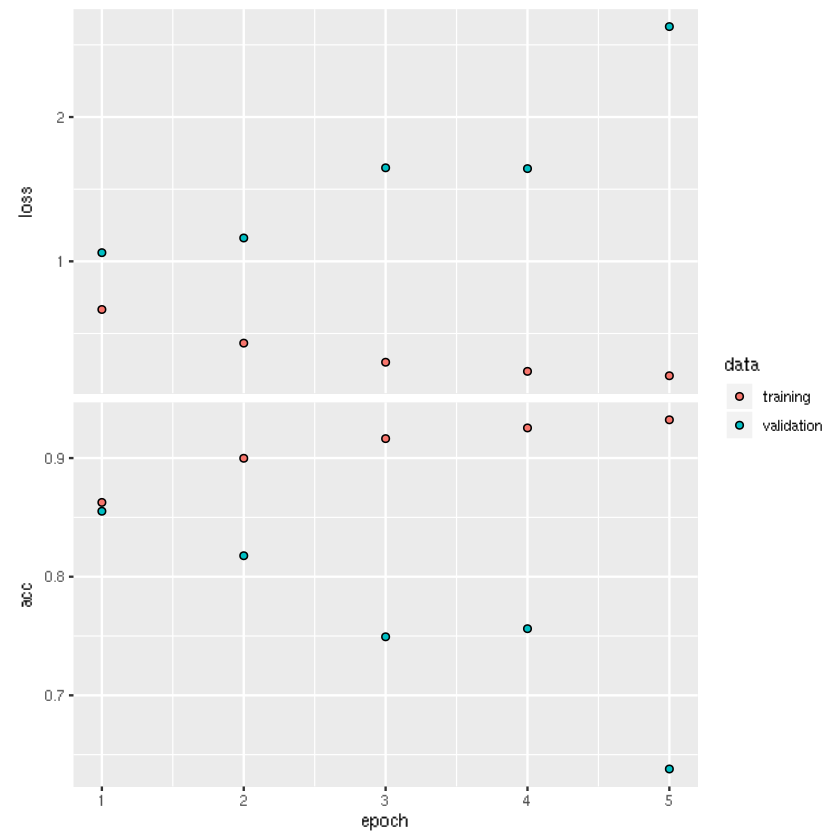

In [36]:
model <- keras_model_sequential() %>%
    smaller_resnet_50() %>%
    layer_batch_normalization() %>%
    layer_flatten() %>%
    layer_dense(units = 10, activation = "softmax", name = 'dense1')

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.001),
    loss = "categorical_crossentropy",
    metric = "acc"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_split=0.2,
    epochs = 5,
    batch_size = 512,
    callbacks=list(Progress$new())
)

plot(history)

From the plot we can see that our model is fairly expressive and we could maybe continue to train it and seen some performance improvements but we leave this is a bonus exercise.

In [37]:
model %>% evaluate(x_test, y_test)

$loss
[1] 2.593685

$acc
[1] 0.6451

In this notebook we saw how to use a pretrained CNN and how we could add our layers to the model so that we can benefit from the generic features learned by the model. Some notes about this notebook.
- Our images are only grayscale, but the model assumed colors. We can expect this to have some negative (or at least wasted computation) on our performance.
- We needed to resize our images in order for them to fit. We can also expect this to have negative impact on performance.

## Bonus Excercise
Try improving the model above. Consider the options below
- Adding more layers from the ResNet50 model
- Adding dropout.
- Adding more dense layers/more dense units.

In [ ]:
smaller_resnet_50 <- keras_model(inputs = resnet_50_model$input, 
                                 outputs = get_layer(resnet_50_model, 'activation_48')$output)
freeze_weights(smaller_resnet_50)
model <- keras_model_sequential() %>%
    smaller_resnet_50 %>%
    layer_dropout(0.2) %>%
    layer_flatten() %>%
    layer_dense(units = 32, activation = "relu") %>%
    layer_dropout(0.2) %>%
    layer_dense(units = 10, activation = "softmax")

cat(summary(model))

model %>% compile(
    optimizer = optimizer_adam(lr = 0.0001),
    loss = "categorical_crossentropy",
    metric = "acc"
)

history <- model %>% fit(
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    epochs = 20,
    batch_size = 128,
    callbacks=list(Progress$new())
)

plot(history)